# Gold Price Forecasting with LSTM Multivariate

## Business Understanding

Tujuan proyek ini adalah memprediksi harga emas di masa depan menggunakan data historis dari Pluang. Dengan prediksi ini, investor atau perusahaan dapat mengambil keputusan investasi emas yang lebih baik.

---

## Data Understanding

### Sumber Data
- Data diambil dari API Pluang: [https://pluang.com/api/asset/gold/pricing?daysLimit=20000](https://pluang.com/api/asset/gold/pricing?daysLimit=20000)

### Jumlah Data
Kita akan menampilkan jumlah baris dan kolom pada dataset.

### Kondisi Data
Kita akan mengecek apakah ada missing value, duplikat, dan outlier pada data.

### Uraian Fitur
- **sell**: Harga jual emas (harga jika Anda menjual emas ke Pluang)
- **buy**: Harga beli emas (harga jika Anda membeli emas dari Pluang secara tunai)
- **installment**: Harga beli emas jika menggunakan metode cicilan
- **tgl**: Tanggal update harga

---

## Import Library

In [1]:
import pandas as pd
import numpy as np
import requests
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

## Scrape Data Harga Emas

Mengambil data harga emas dari API Pluang dan menyimpannya ke dalam file CSV.

In [2]:
# Scrape data dengan API
response = requests.get("https://pluang.com/api/asset/gold/pricing?daysLimit=20000")
coba = response.json()

# Manipulasi data dan transformasi periode data
hargaemas = pd.DataFrame(coba['data']['history'])
hargaemas['tgl'] = pd.to_datetime(hargaemas['updated_at'].str[:10], format="%Y-%m-%d")
hargaemas = hargaemas.iloc[:, [1, 2, 3, 5]]

# Simpan ke CSV
hargaemas.to_csv('hargaemas.csv', index=False)

# Tampilkan 5 data teratas
hargaemas.head()

,sell,buy,installment,tgl
0,1867039,1820363,1867039,2025-05-25
1,1867039,1820363,1867039,2025-05-24
2,1867474,1820787,1867474,2025-05-23
3,1867296,1820613,1867296,2025-05-22
4,1840675,1794658,1840675,2025-05-21


## Data Exploration

Melakukan eksplorasi awal data untuk mengetahui jumlah baris dan kolom, mengecek missing value, duplikat, dan outlier pada harga jual emas.

Jumlah baris: 2001
Jumlah kolom: 4
Missing value per kolom:
sell           0
buy            0
installment    0
tgl            0
dtype: int64
Jumlah data duplikat: 4


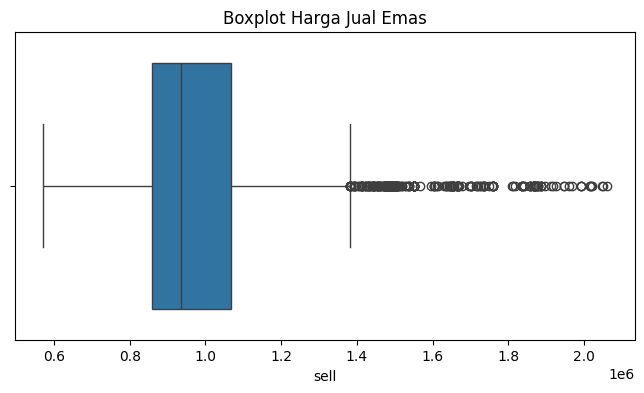

In [3]:
# Membaca file CSV
file_path = 'hargaemas.csv'
data = pd.read_csv(file_path)

# Jumlah baris dan kolom
print(f"Jumlah baris: {data.shape[0]}")
print(f"Jumlah kolom: {data.shape[1]}")

# Cek missing value
print("Missing value per kolom:")
print(data.isnull().sum())

# Cek duplikat
print(f"Jumlah data duplikat: {data.duplicated().sum()}")

# Cek outlier pada kolom 'sell'
plt.figure(figsize=(8, 4))
sns.boxplot(x=data['sell'])
plt.title('Boxplot Harga Jual Emas')
plt.show()

### Insight Data Awal Harga Emas

- **Jumlah Baris:** 2001  
    Dataset memiliki 2001 baris data historis harga emas.

- **Jumlah Kolom:** 4  
    Terdiri dari kolom: `sell`, `buy`, `installment`, dan `tgl`.

- **Missing Value:**  
    Tidak ditemukan missing value pada seluruh kolom, sehingga data sudah lengkap.

- **Duplikat:**  
    Terdapat 4 baris data duplikat berdasarkan seluruh kolom. Duplikat ini perlu dihapus agar analisis dan model prediksi lebih akurat.

Insight ini menunjukkan data cukup bersih dan lengkap, namun perlu penanganan pada data duplikat sebelum proses modeling lebih lanjut.

## Data Preparation

Pada tahap ini dilakukan:
- Membaca data harga emas dari file `hargaemas.csv`.
- Mengonversi kolom `tgl` menjadi tipe datetime agar bisa diurutkan dan diproses sebagai tanggal.
- Mengurutkan data berdasarkan tanggal (`tgl`) dari paling lama ke paling baru.
- Menghapus data duplikat berdasarkan tanggal, hanya menyisakan data terakhir untuk setiap tanggal.
- Melakukan interpolasi untuk mengisi missing value (jika ada) pada data numerik.
- Menjadikan kolom `tgl` sebagai index dataframe.
- Menambahkan fitur statistik: moving average 30 hari (`ma30`) dan standar deviasi rolling 30 hari (`std30`) pada harga jual emas.
- Visualisasi data harga jual emas historis untuk melihat tren harga dari waktu ke waktu.

C:\Users\rizal\AppData\Local\Temp\ipykernel_33992\4162662594.py:9: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data['ma30'] = data['sell'].rolling(30).mean().fillna(method='bfill')
C:\Users\rizal\AppData\Local\Temp\ipykernel_33992\4162662594.py:10: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data['std30'] = data['sell'].rolling(30).std().fillna(method='bfill')


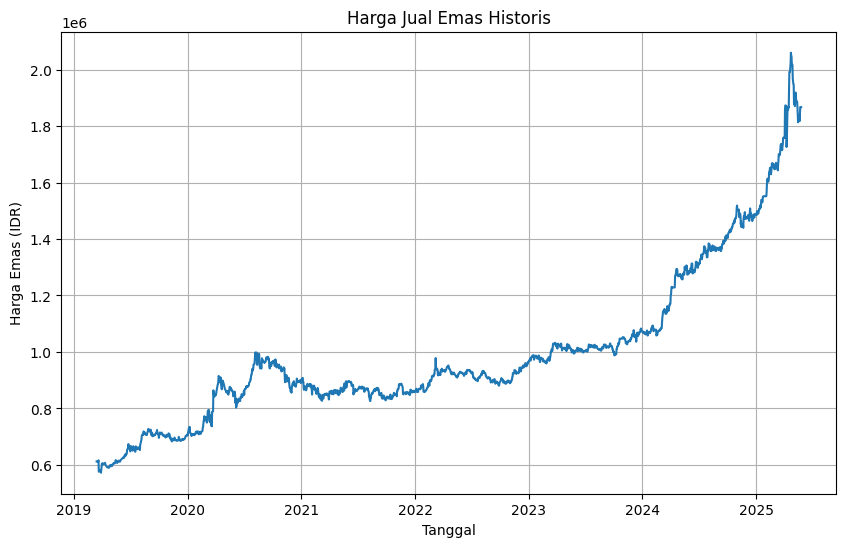

In [5]:
data = pd.read_csv('hargaemas.csv')
data['tgl'] = pd.to_datetime(data['tgl'])
data = data.sort_values('tgl')
data = data[~data['tgl'].duplicated(keep='last')]
data = data.interpolate()
data.set_index('tgl', inplace=True)

# Tambahkan fitur moving average dan rolling std
data['ma30'] = data['sell'].rolling(30).mean().fillna(method='bfill')
data['std30'] = data['sell'].rolling(30).std().fillna(method='bfill')

# Visualisasi data harga jual emas
plt.figure(figsize=(10, 6))
plt.plot(data.index, data['sell'])
plt.title('Harga Jual Emas Historis')
plt.xlabel('Tanggal')
plt.ylabel('Harga Emas (IDR)')
plt.grid(True)
plt.show()

## Insight dari Gambar

**Tren Harga Emas Historis**  
Dari visualisasi harga emas historis, terlihat bahwa harga emas cenderung mengalami kenaikan dalam jangka panjang, meskipun terdapat fluktuasi jangka pendek. Tren ini menunjukkan bahwa emas tetap menjadi aset yang stabil dan bernilai untuk investasi jangka panjang.


## Data Normalization & Sequence for LSTM

LSTM membutuhkan data dalam bentuk sequence (window).  
Di sini kita gunakan window_size = 30 (menggunakan 30 hari terakhir untuk memprediksi hari berikutnya).

Pada bagian kode berikut:
- Data multivariate (`sell`, `ma30`, `std30`) dinormalisasi ke rentang 0-1 menggunakan `MinMaxScaler` agar model lebih stabil saat training.
- Data diubah menjadi bentuk sequence (window) sepanjang 30 hari untuk setiap sampel input LSTM, dengan target prediksi adalah harga `sell` pada hari ke-31.
- Hasil akhirnya adalah array `X` (fitur berurutan) dan `y` (target harga jual) yang siap digunakan untuk training LSTM.

In [6]:
#Normalisasi Multivariate
# --------------------------
features = ['sell', 'ma30', 'std30']
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(data[features])

#Sequence Multivariate untuk LSTM
# -----------------------------------
window_size = 30
X, y = [], []
for i in range(window_size, len(data_scaled)):
    X.append(data_scaled[i-window_size:i])
    y.append(data_scaled[i, 0])  # Target: harga 'sell'
X, y = np.array(X), np.array(y)

## Train-Test Split

Membagi data menjadi data latih (train) dan data uji (test) untuk evaluasi model.

In [7]:
split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

print(f"Jumlah data train: {len(X_train)}")
print(f"Jumlah data test: {len(X_test)}")

Jumlah data train: 1542
Jumlah data test: 386


## Train-Test Split Summary

- **Jumlah Data Train:** 1542  
    Data ini digunakan untuk melatih model LSTM agar dapat mempelajari pola historis harga emas.

- **Jumlah Data Test:** 386  
    Data ini digunakan untuk menguji performa model pada data yang belum pernah dilihat sebelumnya, sehingga dapat mengevaluasi kemampuan generalisasi model.
```

## Membangun dan Melatih Model LSTM

Membangun model LSTM sederhana untuk prediksi harga emas.

In [8]:
model = Sequential()
model.add(LSTM(128, return_sequences=True, input_shape=(window_size, X.shape[2])))
model.add(Dropout(0.2))
model.add(LSTM(64))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')
history = model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=32,
    validation_data=(X_test, y_test),
    verbose=1
)
model.save('model_lstm_multivariate_emas.h5')


Epoch 1/100


c:\laragon\bin\python\python-3.10\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


49/49 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - loss: 0.0091 - val_loss: 0.0044
Epoch 2/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 2.3150e-04 - val_loss: 6.9470e-04
Epoch 3/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 2.2373e-04 - val_loss: 6.6051e-04
Epoch 4/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 1.9131e-04 - val_loss: 6.4591e-04
Epoch 5/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 1.7693e-04 - val_loss: 6.8403e-04
Epoch 6/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 1.8050e-04 - val_loss: 6.2682e-04
Epoch 7/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 1.8225e-04 - val_loss: 9.0701e-04
Epoch 8/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 1.6036e-04 - val_loss: 0.0010
Epoch 9/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 1.3661e-04 - val_loss: 0.0018
Epoch 10/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 1.4409e-04 - val_loss: 0.0023
Epoch 11/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 1.3045e-04 - val_loss: 5.7793e

## Visualisasi Loss Selama Training

Melihat apakah model mengalami overfitting atau tidak.

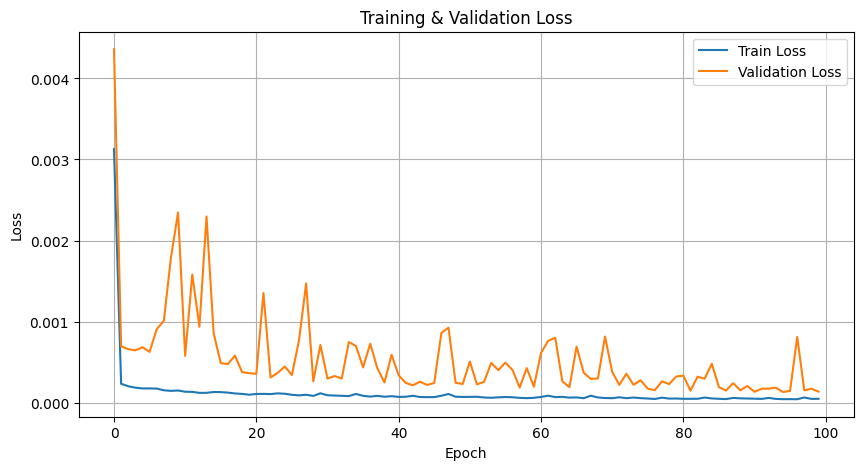

In [9]:
# Visualisasi Loss Selama Training
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training & Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

### Insight dari Gambar Training & Validation Loss

- **Stabilitas Model:**  
    Grafik menunjukkan bahwa nilai loss pada data training dan validasi cenderung stabil setelah beberapa epoch. Hal ini menunjukkan bahwa model telah belajar dengan baik tanpa mengalami overfitting atau underfitting yang signifikan.

- **Perbedaan Loss:**  
    Terdapat sedikit perbedaan antara training loss dan validation loss, yang menunjukkan bahwa model memiliki kemampuan generalisasi yang cukup baik pada data yang belum pernah dilihat sebelumnya.

- **Konvergensi:**  
    Loss pada data training dan validasi menurun secara konsisten selama proses training, yang menunjukkan bahwa model berhasil mempelajari pola dari data historis harga emas.

Insight ini menunjukkan bahwa model LSTM multivariate yang dibangun cukup baik dalam mempelajari pola data dan memiliki potensi untuk memberikan prediksi yang akurat.
```

## Evaluasi Model LSTM

Melakukan prediksi pada data test dan menghitung MAE serta RMSE.

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
MAE LSTM Multivariate: 10677.87
RMSE LSTM Multivariate: 17364.33


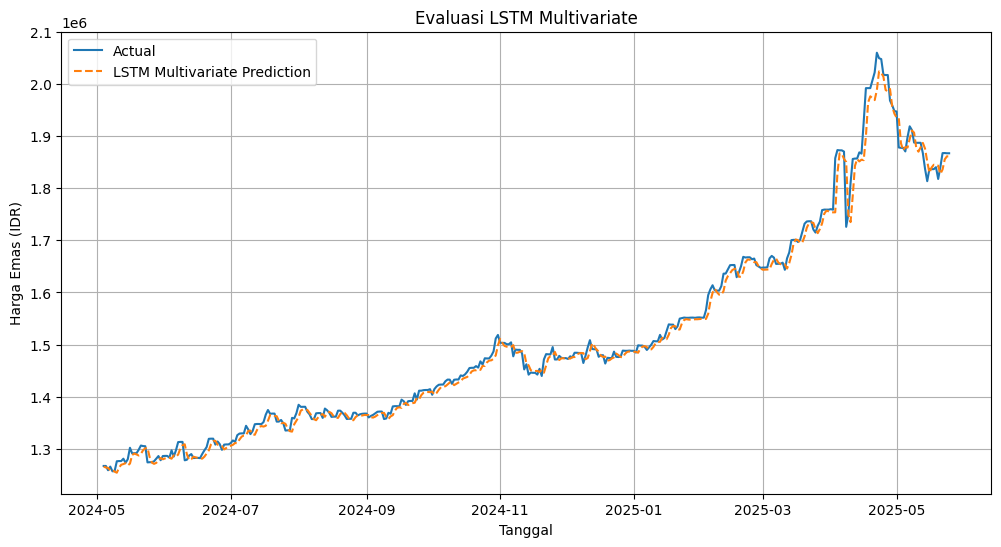

In [10]:
# Evaluasi Model LSTM
from sklearn.metrics import mean_absolute_error, mean_squared_error

#Evaluasi Model pada Data Test
# -------------------------------
y_pred = model.predict(X_test)

# Invers transformasi ke skala asli (khusus kolom 'sell')
def inverse_multivariate(y_scaled, X_last, scaler):
    # Gabungkan prediksi dengan fitur lain agar bisa inverse_transform
    y_full = np.concatenate([y_scaled, X_last[:, 1:]], axis=1)
    return scaler.inverse_transform(y_full)[:, 0]

y_test_inv = inverse_multivariate(y_test.reshape(-1,1), X_test[:,-1,:], scaler)
y_pred_inv = inverse_multivariate(y_pred, X_test[:,-1,:], scaler)

mae = mean_absolute_error(y_test_inv, y_pred_inv)
rmse = np.sqrt(mean_squared_error(y_test_inv, y_pred_inv))
print(f"MAE LSTM Multivariate: {mae:.2f}")
print(f"RMSE LSTM Multivariate: {rmse:.2f}")

# Visualisasi prediksi vs aktual
test_index = data.index[-len(y_test_inv):]
plt.figure(figsize=(12,6))
plt.plot(test_index, y_test_inv, label='Actual')
plt.plot(test_index, y_pred_inv, label='LSTM Multivariate Prediction', linestyle='--')
plt.legend()
plt.title('Evaluasi LSTM Multivariate')
plt.xlabel('Tanggal')
plt.ylabel('Harga Emas (IDR)')
plt.grid(True)
plt.show()

## Evaluasi Model LSTM Multivariate untuk Prediksi Harga Emas

Pada gambar di atas, kita dapat melihat perbandingan antara harga emas yang sebenarnya (Actual) dengan prediksi yang dihasilkan oleh model LSTM Multivariate (LSTM Multivariate Prediction). Garis biru mewakili data harga emas yang sesungguhnya, sedangkan garis oranye putus-putus menunjukkan hasil prediksi model LSTM.

### Insight Utama:

1. **Performa Model:**
   - Secara umum, model LSTM Multivariate dapat memprediksi pergerakan harga emas dengan cukup akurat, mengikuti tren naik dan turun pada data aktual. Meskipun ada beberapa titik dimana prediksi sedikit menyimpang, garis prediksi tetap cukup dekat dengan data aktual.
   
2. **Kesalahan Model:**
   - **MAE (Mean Absolute Error):** 10,677.87 IDR
   - **RMSE (Root Mean Squared Error):** 17,364.33 IDR
   - Kedua metrik ini menunjukkan bahwa model memiliki kesalahan rata-rata sekitar 10,678 IDR, dan deviasi standar kesalahan prediksi sekitar 17,364 IDR. Meskipun model cukup akurat dalam tren pergerakan harga, masih ada beberapa kesalahan yang perlu diperbaiki, terutama pada fluktuasi harga yang sangat tajam.

3. **Kesimpulan:**
   - Model LSTM Multivariate menunjukkan performa yang baik dalam memprediksi harga emas dengan akurasi yang tinggi pada tren jangka panjang. Namun, masih ada ruang untuk perbaikan dalam mengatasi fluktuasi harga yang lebih tajam atau mendalam.
   - Penggunaan model LSTM dalam analisis harga komoditas seperti emas dapat memberikan wawasan yang berguna, meskipun model ini masih dapat lebih dioptimalkan dengan melibatkan lebih banyak variabel atau teknik perbaikan seperti tuning hyperparameter.


## Prediksi Harga Emas 300 Hari ke Depan dengan LSTM



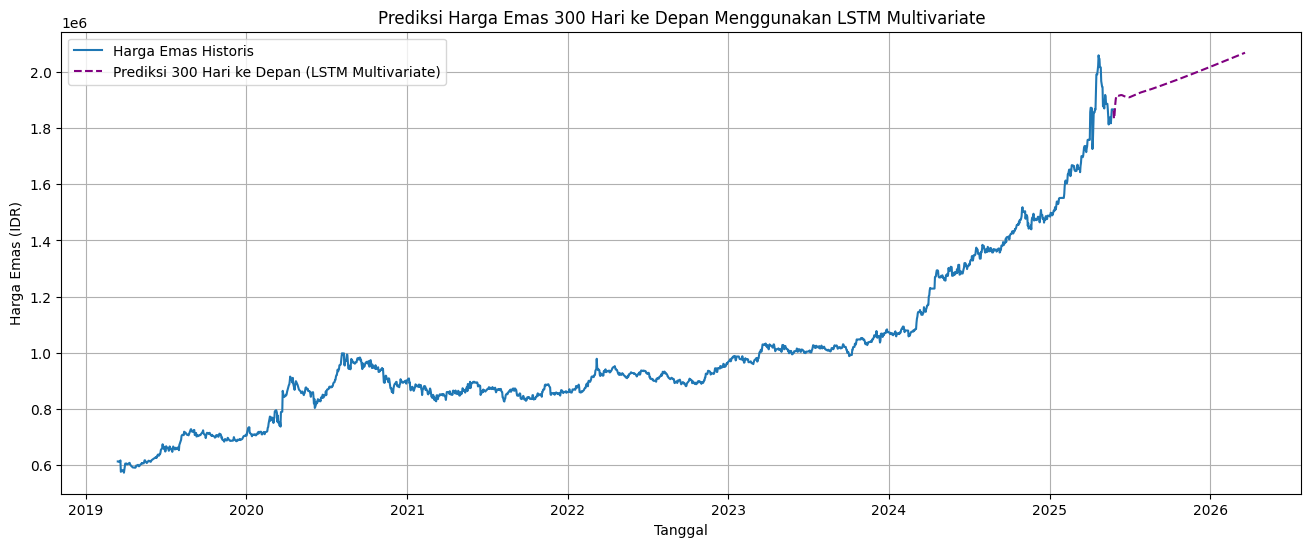

Prediksi harga emas pada 2026-03-21: 2,069,221 IDR


In [12]:
# 8. Prediksi Masa Depan (Multi-step Forecasting)
# -----------------------------------------------
future_steps = 300  # Ganti sesuai kebutuhan
last_sequence = data_scaled[-window_size:]
future_preds = []

for _ in range(future_steps):
    input_seq = last_sequence.reshape(1, window_size, X.shape[2])
    next_pred_scaled = model.predict(input_seq, verbose=0)[0, 0]
    # Update fitur moving average dan std dengan prediksi baru
    next_ma = last_sequence[-30:, 0].mean()
    next_std = last_sequence[-30:, 0].std()
    next_row = np.array([next_pred_scaled, next_ma, next_std])
    future_preds.append(next_row)
    last_sequence = np.vstack([last_sequence[1:], next_row])

future_preds = np.array(future_preds)
future_preds_inv = scaler.inverse_transform(future_preds)[:, 0]
future_dates = pd.date_range(data.index[-1] + pd.Timedelta(days=1), periods=future_steps, freq='D')

# Plot hasil prediksi masa depan
plt.figure(figsize=(16,6))
plt.plot(data.index, data['sell'], label='Harga Emas Historis')
plt.plot(future_dates, future_preds_inv, label=f'Prediksi {future_steps} Hari ke Depan (LSTM Multivariate)', color='purple', linestyle='--')
plt.legend()
plt.title(f'Prediksi Harga Emas {future_steps} Hari ke Depan Menggunakan LSTM Multivariate')
plt.xlabel('Tanggal')
plt.ylabel('Harga Emas (IDR)')
plt.grid(True)
plt.show()

print(f"Prediksi harga emas pada {future_dates[-1].date()}: {future_preds_inv[-1]:,.0f} IDR")

## Prediksi Harga Emas 300 Hari ke Depan Menggunakan LSTM Multivariate

Pada gambar di atas, kita dapat melihat perbandingan antara harga emas historis dengan prediksi harga emas selama 300 hari ke depan menggunakan model LSTM Multivariate. Garis biru menunjukkan harga emas yang sesungguhnya, sementara garis putus-putus ungu mewakili prediksi harga emas di masa depan.

### Insight Utama:

1. **Tren Prediksi:**
   - Model LSTM berhasil memprediksi tren harga emas dengan cukup baik, mengikuti pola harga historis hingga 2025. Namun, prediksi harga emas ke depan terlihat terus naik, mencerminkan tren yang diperkirakan terus berlanjut.

2. **Prediksi Harga 2026:**
   - Berdasarkan model, harga emas pada 2026 diperkirakan mencapai 2,069,221 IDR. Ini menunjukkan ekspektasi kenaikan harga emas yang signifikan dalam waktu yang akan datang.

3. **Validitas Prediksi:**
   - Meskipun model LSTM memberikan prediksi yang mengikuti tren historis, prediksi jangka panjang selalu rentan terhadap ketidakpastian, dan fluktuasi pasar atau faktor eksternal lainnya dapat mempengaruhi hasil aktual.

4. **Kesimpulan:**
   - Model LSTM Multivariate menunjukkan potensi yang baik untuk memprediksi pergerakan harga emas dalam jangka panjang. Namun, penting untuk terus memantau dan memperbarui model berdasarkan data terbaru agar prediksi tetap relevan dan akurat.
